In [1]:
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('./g-research-crypto-forecasting/train.csv')
df.dropna(axis = 0, inplace = True)

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [2]:
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]
BATCH_SIZE = 5
SEQ_LENGTH = 20

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

def create_xy_pairs(X_series, y_series, seq_length):
    data_length = len(X_series)
    pairs = []
    for idx in range(data_length - seq_length):
        x = X_series[idx:idx + seq_length]
        y = y_series[idx + seq_length:idx + seq_length + 1]
        pairs.append((x, y))
    return pairs

In [3]:
data = df.set_index("timestamp")
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X = pd.concat([log_return(data[data["Asset_ID"]==0].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==0].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==0]), lower_shadow(data[data["Asset_ID"]==0]), \
               log_return(data[data["Asset_ID"]==1].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==1].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==1]), lower_shadow(data[data["Asset_ID"]==1]), \
               log_return(data[data["Asset_ID"]==2].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==2].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==2]), lower_shadow(data[data["Asset_ID"]==2]), \
               log_return(data[data["Asset_ID"]==3].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==3].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==3]), lower_shadow(data[data["Asset_ID"]==3]), \
               log_return(data[data["Asset_ID"]==4].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==4].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==4]), lower_shadow(data[data["Asset_ID"]==4]), \
               log_return(data[data["Asset_ID"]==5].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==5].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==5]), lower_shadow(data[data["Asset_ID"]==5]), \
               log_return(data[data["Asset_ID"]==6].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==6].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==6]), lower_shadow(data[data["Asset_ID"]==6]), \
               log_return(data[data["Asset_ID"]==7].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==7].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==7]), lower_shadow(data[data["Asset_ID"]==7]), \
               log_return(data[data["Asset_ID"]==8].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==8].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==8]), lower_shadow(data[data["Asset_ID"]==8]), \
               log_return(data[data["Asset_ID"]==9].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==9].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==9]), lower_shadow(data[data["Asset_ID"]==9]), \
               log_return(data[data["Asset_ID"]==10].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==10].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==10]), lower_shadow(data[data["Asset_ID"]==10]), \
               log_return(data[data["Asset_ID"]==11].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==11].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==11]), lower_shadow(data[data["Asset_ID"]==11]), \
               log_return(data[data["Asset_ID"]==12].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==12].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==12]), lower_shadow(data[data["Asset_ID"]==12]), \
               log_return(data[data["Asset_ID"]==13].VWAP,periods=5), \
               log_return(data[data["Asset_ID"]==13].VWAP,periods=1).abs(), \
               upper_shadow(data[data["Asset_ID"]==13]), lower_shadow(data[data["Asset_ID"]==13]), \
              ], axis=1)
y = data[data["Asset_ID"]==0].Target

X = X.loc[y.index].fillna(0)
    
X_train = X.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_train = y.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_test = X.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_test = y.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
    
train = create_xy_pairs(X_train_scaled, y_train, SEQ_LENGTH)
test = create_xy_pairs(X_test_scaled, y_test, SEQ_LENGTH)

train_dl = DataLoader(train, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_dl = DataLoader(test, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

/Users/shawin/miniforge3/envs/m1/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

EPOCHS        = 100
DROPOUT       = 0.1
NUM_LAYERS    = 2
INPUT_DIM     = 56
OUTPUT_SIZE   = 1
HIDDEN_SIZE   = 200
LEARNING_RATE = 0.0001
STATE_DIM     = NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden(self, batch_size):
        state_dim = (self.num_layers, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        out = self.linear(x)
        return out, (h, c)

model = LSTM(
    INPUT_DIM,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [5]:
def training(model, epochs, validate_every=2):

    training_losses = []
    coefficient = []
    
    # Set to train mode
    model.train()
    
    # Initialize hidden and cell states with dimension:
    # (num_layers * num_directions, batch, hidden_size)
    states = model.init_hidden(BATCH_SIZE)

    for epoch in tqdm(range(epochs)):

        running_training_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(train_dl):
            # Convert to Tensors
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)
      
            # Truncated Backpropagation
            states = [state.detach() for state in states]          

            optimizer.zero_grad()

            # Make prediction
            output, states = model(x_batch, states)

            # Calculate loss
            loss = criterion(output[:, -1, :], y_batch)
            loss.backward()
            running_training_loss += loss.item()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        
        # Average loss across timesteps
        training_losses.append(running_training_loss / len(train_dl))
        
        #predict
        if (epoch+1) % 5 == 0:
            # Set to eval mode
            model.eval()
            #torch.no_grad()
            
            pred = []
            for idx, (x_batch, y_batch) in enumerate(test_dl):
                # Convert to Tensors
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)
                
                validation_states = [state.detach() for state in states]
                output, _ = model(x_batch, validation_states)
                output = output[:, -1, :].flatten().tolist()
                pred += output
            pred_btc = np.array(pred)
            test_btc = y_test[20:len(pred_btc)+20]
            coef = np.corrcoef(pred_btc, test_btc)[0,1]
            coefficient.append(coef)
            print('Epoch %i : corrcoef is %f.' %(epoch+1,coef))
        
        
    # Visualize loss
    epoch_count = range(1, len(training_losses) + 1)
    plt.plot(epoch_count, training_losses, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    coef_epoch_count = range(5, (len(coefficient)+1)*5, 5)
    plt.plot(coef_epoch_count, coefficient, 'b--')
    plt.xticks(coef_epoch_count)
    plt.legend(['Correlation Coefficient'])
    plt.xlabel('Epoch')
    plt.ylabel('Coefficient')
    plt.show()

In [6]:
training(model, 100)

  5%|▌         | 5/100 [07:00<2:12:58, 83.98s/it]

Epoch 5 : corrcoef is 0.019988.


 10%|█         | 10/100 [13:47<2:06:55, 84.62s/it]

Epoch 10 : corrcoef is 0.029372.


 13%|█▎        | 13/100 [17:38<1:58:01, 81.39s/it]


KeyboardInterrupt: 

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

EPOCHS        = 100
DROPOUT       = 0.1
NUM_LAYERS    = 3
INPUT_DIM     = 56
OUTPUT_SIZE   = 1
HIDDEN_SIZE   = 100
LEARNING_RATE = 0.0001
STATE_DIM     = NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden(self, batch_size):
        state_dim = (self.num_layers, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        out = self.linear(x)
        return out, (h, c)

model = LSTM(
    INPUT_DIM,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

 12%|█▎        | 5/40 [08:59<1:06:48, 114.52s/it]

Epoch 5 : corrcoef is 0.003151.


 25%|██▌       | 10/40 [18:08<57:29, 114.98s/it] 

Epoch 10 : corrcoef is 0.011179.


 38%|███▊      | 15/40 [27:19<48:10, 115.62s/it]

Epoch 15 : corrcoef is 0.014961.


 50%|█████     | 20/40 [36:30<38:33, 115.67s/it]

Epoch 20 : corrcoef is 0.017467.


 62%|██████▎   | 25/40 [45:14<27:44, 110.94s/it]

Epoch 25 : corrcoef is 0.019229.


 75%|███████▌  | 30/40 [53:57<18:18, 109.88s/it]

Epoch 30 : corrcoef is 0.020536.


 88%|████████▊ | 35/40 [1:02:40<09:08, 109.80s/it]

Epoch 35 : corrcoef is 0.021532.


100%|██████████| 40/40 [1:11:24<00:00, 107.12s/it]

Epoch 40 : corrcoef is 0.022289.


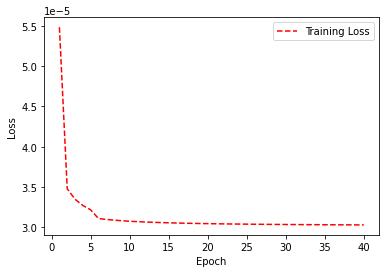

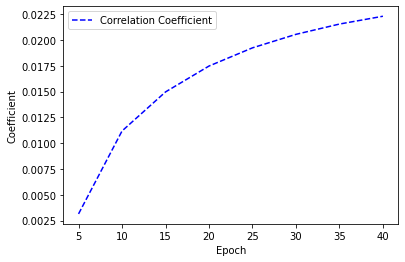

In [ ]:
training(model, 40)

 10%|█         | 5/50 [08:16<1:18:20, 104.47s/it]

Epoch 5 : corrcoef is -0.011135.


 20%|██        | 10/50 [16:10<1:07:43, 101.59s/it]

Epoch 10 : corrcoef is 0.000040.


 30%|███       | 15/50 [24:35<1:01:23, 105.24s/it]

Epoch 15 : corrcoef is 0.009212.


 40%|████      | 20/50 [33:32<57:26, 114.89s/it]  

Epoch 20 : corrcoef is 0.016192.


 50%|█████     | 25/50 [42:54<49:09, 118.00s/it]

Epoch 25 : corrcoef is 0.021715.


 60%|██████    | 30/50 [52:12<39:16, 117.81s/it]

Epoch 30 : corrcoef is 0.026134.


 70%|███████   | 35/50 [1:01:29<29:26, 117.79s/it]

Epoch 35 : corrcoef is 0.029620.


 80%|████████  | 40/50 [1:10:43<19:32, 117.23s/it]

Epoch 40 : corrcoef is 0.032334.


 90%|█████████ | 45/50 [1:19:58<09:45, 117.20s/it]

Epoch 45 : corrcoef is 0.034417.


100%|██████████| 50/50 [1:29:14<00:00, 107.09s/it]

Epoch 50 : corrcoef is 0.035996.


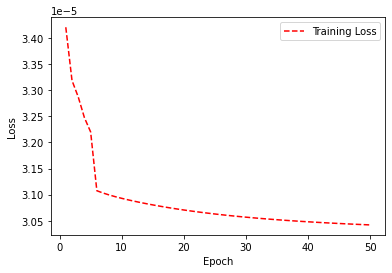

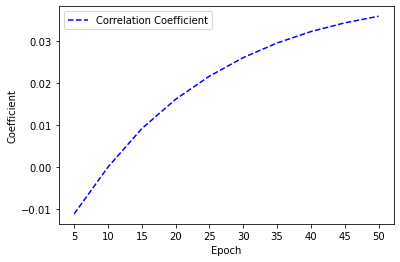

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

EPOCHS        = 100
DROPOUT       = 0.1
NUM_LAYERS    = 4
INPUT_DIM     = 56
OUTPUT_SIZE   = 1
HIDDEN_SIZE   = 56
LEARNING_RATE = 0.0001
STATE_DIM     = NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden(self, batch_size):
        state_dim = (self.num_layers, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        out = self.linear(x)
        return out, (h, c)

model = LSTM(
    INPUT_DIM,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
training(model, 50)

  5%|▌         | 5/100 [23:04<7:36:12, 288.13s/it]

Epoch 5 : corrcoef is 0.024417.


 10%|█         | 10/100 [45:23<7:08:59, 286.00s/it]

Epoch 10 : corrcoef is 0.028395.


 15%|█▌        | 15/100 [1:07:07<6:32:48, 277.28s/it]

Epoch 15 : corrcoef is 0.028790.


 20%|██        | 20/100 [1:28:55<6:08:26, 276.33s/it]

Epoch 20 : corrcoef is 0.028983.


 25%|██▌       | 25/100 [1:50:35<5:44:01, 275.22s/it]

Epoch 25 : corrcoef is 0.029298.


 30%|███       | 30/100 [2:12:18<5:21:40, 275.72s/it]

Epoch 30 : corrcoef is 0.029583.


 35%|███▌      | 35/100 [2:33:59<4:58:11, 275.25s/it]

Epoch 35 : corrcoef is 0.029881.


 40%|████      | 40/100 [2:54:56<4:25:29, 265.50s/it]

Epoch 40 : corrcoef is 0.030261.


 45%|████▌     | 45/100 [3:15:27<3:59:31, 261.31s/it]

Epoch 45 : corrcoef is 0.030549.


 50%|█████     | 50/100 [3:36:03<3:37:33, 261.08s/it]

Epoch 50 : corrcoef is 0.030909.


 55%|█████▌    | 55/100 [3:56:38<3:15:36, 260.82s/it]

Epoch 55 : corrcoef is 0.031167.


 60%|██████    | 60/100 [4:17:16<2:54:21, 261.53s/it]

Epoch 60 : corrcoef is 0.031542.


 65%|██████▌   | 65/100 [4:37:48<2:32:08, 260.83s/it]

Epoch 65 : corrcoef is 0.031916.


 70%|███████   | 70/100 [4:58:25<2:10:48, 261.61s/it]

Epoch 70 : corrcoef is 0.032191.


 75%|███████▌  | 75/100 [5:19:08<1:49:10, 262.03s/it]

Epoch 75 : corrcoef is 0.032563.


 80%|████████  | 80/100 [5:39:43<1:27:10, 261.50s/it]

Epoch 80 : corrcoef is 0.032868.


 85%|████████▌ | 85/100 [6:00:18<1:05:17, 261.20s/it]

Epoch 85 : corrcoef is 0.033206.


 90%|█████████ | 90/100 [6:20:53<43:32, 261.22s/it]  

Epoch 90 : corrcoef is 0.033584.


 95%|█████████▌| 95/100 [6:41:33<21:50, 262.02s/it]

Epoch 95 : corrcoef is 0.033914.


100%|██████████| 100/100 [7:02:13<00:00, 253.34s/it]

Epoch 100 : corrcoef is 0.034326.


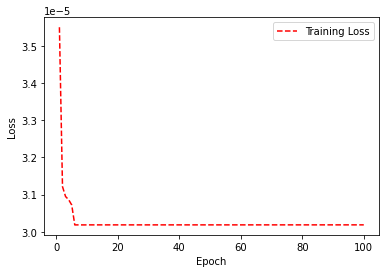

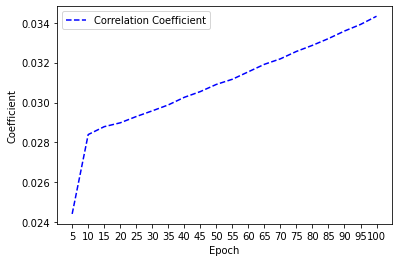

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

EPOCHS        = 100
DROPOUT       = 0.1
NUM_LAYERS    = 10
INPUT_DIM     = 56
OUTPUT_SIZE   = 1
HIDDEN_SIZE   = 56
LEARNING_RATE = 0.0001
STATE_DIM     = NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTM, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden(self, batch_size):
        state_dim = (self.num_layers, batch_size, self.hidden_size)
        return (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        out = self.linear(x)
        return out, (h, c)

model = LSTM(
    INPUT_DIM,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
training(model, 100)

In [ ]:
training(model, 100)

  5%|▌         | 5/100 [23:31<7:51:14, 297.63s/it]

Epoch 5 : corrcoef is 0.034139.


 10%|█         | 10/100 [46:49<7:24:20, 296.23s/it]

Epoch 10 : corrcoef is 0.035635.


 15%|█▌        | 15/100 [1:09:09<6:46:16, 286.78s/it]

Epoch 15 : corrcoef is 0.036049.


 20%|██        | 20/100 [1:32:32<6:34:02, 295.53s/it]

Epoch 20 : corrcoef is 0.036480.


 22%|██▏       | 22/100 [1:41:26<6:05:21, 281.04s/it]